# Install Requirements

In [1]:
%pip install transformers datasets
%pip install torch
%pip install matplotlib
%pip install umap-learn numba==0.48.0
%pip install pandas matplotlib datashader bokeh holoviews colorcet scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numba-0.48.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached llvmlite-0.31.0.tar.gz (110 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.2.tar.gz (86 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.1.tar.gz (80 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.0.tar.gz (81 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap_learn-0.4.6-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [755 lines of output]
      /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-install-icq7xm8a/numba_8217386ddf5949928831ddd7831406d3/setup.py:98: DeprecationWarning:
      
        `

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load Language Model

In [3]:
#MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled" # NL MODEL TODO: is the model trained on lowercased data?

MODEL_NAME = "roberta-base"

#MODEL_NAME = "xlm-roberta-base" # cross-lingual mode (https://huggingface.co/xlm-roberta-base)


In [4]:
from transformers import RobertaModel, AutoTokenizer, RobertaPreTrainedModel, BertModel, GPT2Model, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline('feature-extraction', model=MODEL_NAME, tokenizer=tokenizer)

/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load Data

In [5]:
from pathlib import Path

DATA_DIR = Path.cwd() / "data"

## SemEval 2020 (C)COHA corpus

### Download

In [6]:
from io import BytesIO
from zipfile import ZipFile
import urllib

SEMEVAL_DATA_URL = "https://www2.ims.uni-stuttgart.de/data/sem-eval-ulscd/semeval2020_ulscd_eng.zip"

SEMEVAL2020_DIR = DATA_DIR / "semeval2020_ulscd_eng"

if SEMEVAL2020_DIR.is_dir():
    print(f"Directory '{SEMEVAL2020_DIR}' already exists, skipping corpus download.")
else:
    with urllib.request.urlopen(SEMEVAL_DATA_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(DATA_DIR)

assert SEMEVAL2020_DIR.is_dir(), f"Directory does not exist: '{SEMEVAL2020_DIR}'"


Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/semeval2020_ulscd_eng' already exists, skipping corpus download.


In [7]:
CORPUS1_DIR = SEMEVAL2020_DIR / 'corpus1'
CORPUS2_DIR = SEMEVAL2020_DIR / 'corpus2'
TRUTH_DIR = SEMEVAL2020_DIR / 'truth'

assert CORPUS1_DIR.is_dir(), f"Directory does not exist: '{CORPUS1_DIR}'"
assert CORPUS2_DIR.is_dir(), f"Directory does not exist: '{CORPUS2_DIR}'"
assert TRUTH_DIR.is_dir(), f"Directory does not exist: '{TRUTH_DIR}'"


### Read

In [8]:
TOKENS_FILE1 = CORPUS1_DIR / "token" / "ccoha1.txt.gz"
TOKENS_FILE2 = CORPUS2_DIR / "token" / "ccoha2.txt.gz"

assert TOKENS_FILE1.is_file()
assert TOKENS_FILE2.is_file()

In [9]:
import gzip

with gzip.open(TOKENS_FILE1, 'rt') as f:
    sentences_1810 = f.readlines()

assert len(sentences_1810) == 253644

with gzip.open(TOKENS_FILE2, 'rt') as f:
    sentences_1960 = f.readlines()

assert len(sentences_1960) == 353692

## COHA Corpus (Sample)

### Download

In [10]:
#COHA_DATABASE_URL = 'https://www.corpusdata.org/coha/samples/database.zip'
COHA_TEXT_URL = 'https://www.corpusdata.org/coha/samples/text.zip'

COHA_DIR = DATA_DIR / "COHA"

try:
    COHA_DIR.mkdir(parents=True, exist_ok=False)
except OSError as e:
    print(f"Directory '{COHA_DIR}' already exists: {str(e)}. Skipping corpus download.")
else:
    with urllib.request.urlopen(COHA_TEXT_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(COHA_DIR)

assert COHA_DIR.is_dir()

Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA' already exists: [Errno 17] File exists: '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA'. Skipping corpus download.


### Read

In [11]:
from functools import cached_property
import logging
import re
from typing import Generator, List

FILENAME_PATTERN = r"([a-z]{2,4})_(\d{4})_(\d{3,6})\.txt"
SENTENCE_PATTERN = r"\s*(.*?\s[\.!?\n])"

class CohaDoc:
    _encoding = 'UTF-8'

    def __init__(self, path: Path):
        self._path = path

        try:
            genre, year, id = re.search(FILENAME_PATTERN, self._path.name).groups()
        except AttributeError as e:
            raise ValueError(f"Could not parse path: '{path}': {str(e)}")
        
        self._genre = genre
        self._year = int(year)
        self._id = int(id)

    def __repr__(self) -> str:
        return str(self._path.name)

    @property
    def genre(self) -> str:
        return self._genre

    @property
    def year(self) -> int:
        return self._year

    @property
    def id(self) -> int:
        return self._id
    
    @cached_property
    def text(self):
        with open(self._path, 'rt', encoding=self._encoding) as f:
            return f.read()

    def sentences(self):
        sentences = re.findall(SENTENCE_PATTERN, self.text)
        assert sentences[0].strip() == f"@@{self._id}", f"First line is expected to match document ID ('{self._id}'), but is: {sentences[0]}"
        return sentences[1:]

    def find_sentences(self, term: str) -> List[str]:
        return [
            sentence
            for sentence in self.sentences()
            if term in sentence
        ]
        
    def clean_sentences(self):
        # TODO
        return NotImplemented


In [12]:
coha_docs = [CohaDoc(file) for file in COHA_DIR.glob('*.txt')]

assert len(coha_docs) == 1144

(array([ 12.,  13.,  24.,  50.,  60., 156., 206., 188., 247., 188.]),
 array([1817. , 1836.2, 1855.4, 1874.6, 1893.8, 1913. , 1932.2, 1951.4,
        1970.6, 1989.8, 2009. ]),
 <BarContainer object of 10 artists>)

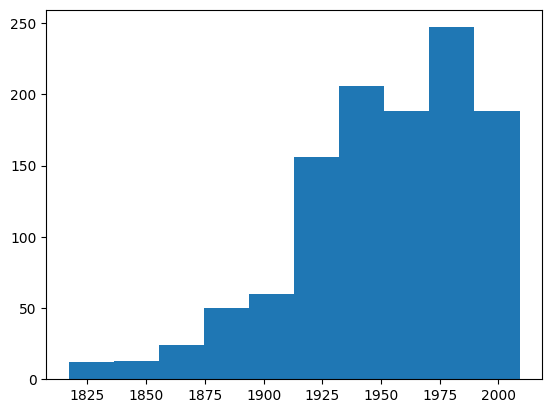

In [13]:
plt.hist([c.year for c in coha_docs])

(array([586.,   0.,   0., 424.,   0.,   0., 108.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

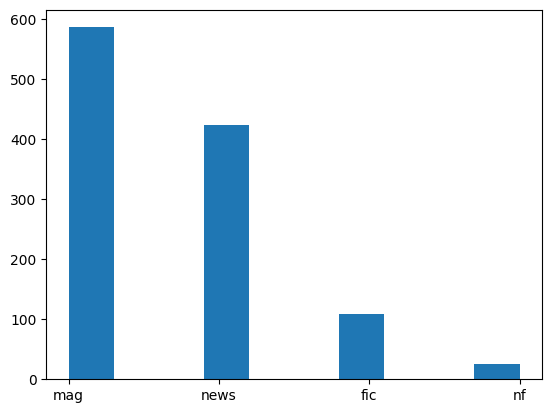

In [14]:
plt.hist([c.genre for c in coha_docs])

# Embeddings

## COHA

In [15]:
TERM1 = 'New York'
TERM2 = 'Philadelphia'

In [16]:

from tqdm import tqdm


for doc in tqdm(coha_docs, unit='doc'):
    if matches := doc.find_sentences(TERM1):
        print(doc)
        print(matches)


  1%|▏         | 17/1144 [00:00<00:07, 143.02doc/s]

news_1953_715250.txt
['House Republican leaders are backing Representative W. Sterling Cole of upstate New York and Senate leaders are supporting , Senator Bourke Hickenlooper of Iowa .']
fic_1979_10650.txt
['Employed by a clothing manufacturer , they were models working out of New York .', 'At the pool , they socialized with wizards of industry and finance , designers from Malibu and Big Sur , political impresariosand their cronies from Washington and New York , the sharks of Palm Beach bridge and backgammon tournaments .', 'Far removed , to New York and New England @ @ @ @ @ @ @ @ @ @ , preoccupied with the children of thesep157unions , they had scant time for Stella , their first daughter , now grown , on the brink of womanhood .', 'He looked like a New York actor , " she laughed.  | " What did he say ?', "I visited him last week in L.A. Otherwise I 'm stillliving in New York .", 'He had seen her in the city twice in June and again in July ; had come to New York for two-day visits .

  8%|▊         | 97/1144 [00:00<00:03, 315.74doc/s]

mag_1981_494150.txt
['THE END OF THE SEVENTIES BY PETER SHAW THE WEATHER UNDERGROUND killings in Nanuet and Nyack , New York , riveted public attention in the way that events do when they seem to carry a lesson or a moral .', '" Times have changed , " wrote William Safire in the New York Times soon afterward .', '" After Cynthia Boston was released , a representative of the New York Civil Liberties Union charged the authorities with " hysteria " in her arrest , which had been made after an eyewitness identification .', "On the day after the Nyack killings , Nathaniel Burns and Samuel Smith were chased through New York City 's borough of Queens by police who recognized the license plate on their car ."]
mag_1995_426450.txt
['" So our only options now are to just breed them as Borneans or to not breed any Borneans  --  which would send the captive population into a crash from @ @ @ @ @ @ @ @ @ @ veterinarian William B. Karesh of the Wildlife Conservation Society , which operates the Bron

 22%|██▏       | 251/1144 [00:00<00:01, 466.89doc/s]

mag_1945_159150.txt
["Currently she is <P> 1 ) acting in Fox 's Centennial Summer , 2 ) doing a daily 15-minute radio show for ABC , 3 ) helping run the New York firm of Constance Bennett Cosmetics Co. by long distance telephone , 4 ) designing a line of Constance Bennett Frocks which will be brought out this fall , 5 ) getting ready to start a daily syndicated newspaper column , 6 ) preparing for an overseas U.S.O. entertainment tour ."]
news_1991_649950.txt
['With the Federal Government and most of the states caught in a budget squeeze  --  New York may have a $4 billion deficit in the next fiscal year , New Jersey faces an $800 million shortfall and Virginia \'s Governor , Doug Wilder , is proposing $1.9 billion in spending cuts  --  a question being asked by the National Council on Crime and Delinquency is right to the point : <p> " Why does our nation spend such an exorbitant amount of money each year to warehouse petty criminals ?', '<p> New York State , for example , now impriso

 36%|███▌      | 414/1144 [00:00<00:01, 639.74doc/s]

fic_1999_44750.txt
["Author Affiliation India Edghill lives in upstate New York and has sold short fiction to Catfantastic IV , Marion Zimmer Bradley 's Fantasy Magazine , and other anthologies and magazines ."]
news_1911_679350.txt
["Charles H. Hyde , New York City 's missing Chamberlain , boarded a train in this city for home this evening .", 'Regarding his absence from New York during the recent bank failures and the hearings before the Legislative Committee , which was investigating the race track gambling fund , and which wanted him as a witness , Mr. Hyde said : " I have not been well for some time , and was advised to take a complete rest .', "There was not the slighcst indication of bank troubles when I left New York , and I had not heard of recent occurrences until Dan Smith , my secretary 's brother , overtook me on my houseboat en route to Palm Beach .", '" Dan Smith , brother of the Chamberlain \'s secretary , who is accompanying the Chamberlain , to New York , said : " I l

 42%|████▏     | 480/1144 [00:01<00:01, 604.79doc/s]

fic_1883_2450.txt
['It was postmarked " New York , " but the hand was large and round and flourished , not in the least like his uncle \'s sexagenarian crabbedness of hieroglyphic .', 'Screw and Scratch of Pine Street , New York , could possibly want of Claudius , Phil.D. of Heidelberg .', 'The first part of the letter contained the formal announcement of the sudden decease of Gustavus Lindstrand , of the firm of Barker and Lindstrand of New York .', 'Screw and Scratch of Pine Street , New York .', '" Dr. Claudius , the nephew of the late Mr. Gustavus Lindstrand of New York ?', 'of course , " interrupted the other , " I am Mr. Barker -- Silas B. Barker junior of New York , and my father was your uncle \'s partner .', '" Claudius proceeded to explain how little he cared for the things that his money might bring him , and announced his intention of @ @ @ @ @ @ @ @ @ @ Mr. Silas B. Barker junior of New York opened his small eyes wider and wider , as his host set forth his views .', 'Mr. B

 53%|█████▎    | 604/1144 [00:01<00:00, 553.89doc/s]

news_1957_718550.txt
['A glance at the map suffices to prove the point that Cyprus is to Turkey what Long Island is to New York .', 'NIHAT New York , Feb. 8 , 1957 .', 'GEORGE LAWTON , New York , Feb. 6 , 1957 .', 'For Safer Night Driving To THE EDITOR OF THE New York Miss : I was happy to see that you found the decision of the authorities to lighten a section of she Connecticut Turnpike of sufficient importance tcl comment favorably on it in an editorial on Feb. 4 .', 'A. DAVID GUREWITSCH , M. D. New York , Feb. 5 , 1957 .']
fic_1920_550.txt
['THE DRUMS OF JEOPARDY By Harold MacGrath CHAPTER I A fast train drew into Albany , on the New York Central , from the West .', 'Sixteen thousand miles , always eastward , on horses , camels , donkeys , trains , and ships ; down China to the sea , over that to San Francisco , thence across this bewildering stretch of cities and plains called the United States , always and ever toward New York  --  and the fool thought he could escape !', 'Neverth

 64%|██████▍   | 730/1144 [00:01<00:00, 541.52doc/s]

fic_1942_13850.txt
['How am I going to get from a little town in Texas to New York ?']
nf_1991_774050.txt
['Dr. H. F. Hintz of Cornell University ( 80 ) reported that in New York the analysis of more than 5000 samples of forages by the New York dairy forage testing laboratory showed an average of less than 7 ppm of copper .']
fic_1919_1550.txt
["' The following States have abolished the teaching of German : Massachusetts , Connecticut , New York , New Jersey , Pennsylvania , Maryland , Virginia , Georgia , Mississippi , Indiana , Ohio , Illinois , Nebraska , Missouri , Kansas , Iowa , Arkansas , Arizona , Colorado , Montana , California , and Oregon .", 'Her beams silver-plated the weird architecture of the shrines of Commerce which face the great Temple dedicated to the Three Muses of New York  --  Astor , Lenox , and Tilden .', 'I have been in New York more than twenty years and never seen any one like you before !', 'Here he can not hurt me , for they will never let that man do anyt

 73%|███████▎  | 840/1144 [00:01<00:00, 489.00doc/s]

nf_1842_747950.txt
['Declines an invitation to Roseneath High aims and resolutions Opinion respecting the Zodiacal Light Progress of his treatise on Practical Astronomy Visit to New York Intense interest in astronomy Indifference to all other attractions of the metropolis Proffered situation at Western Reserve College Scheme for the restoration of his health .', '" In a letter written to his aunt while she was from home , the previous year , he mentions as having found in a neighboring library " several \' very interesting books , such as Stewart on the Steam Engine , and Wood on Railroads. " /z/ Mrs. T. proceeds : " I took him to the toyshops in Broadway ( New York ) with the view of watching the effect on his mind .', "He had come by sea from Richmond to New York , and found his way thence to his father 's new home .", 'I intended to go from New York on Friday evening , when I could have company ; but that very day , at dinner , I heard that there was a sloop going to Nantucket next 

 85%|████████▌ | 974/1144 [00:01<00:00, 560.36doc/s]

mag_1842_555050.txt
["After ten days in Batavia , he sailed with his baggage , specie , and George , in the ship Swift , of New York , for Canton ; the @ @ @ @ @ @ @ @ @ @ Having removed my baggage and specie from the Beisey to the Swift , we sailed next morning , the 12th of September , for Canton , in company with two of the Danish East India Company 's ships , the commanders of which agreed to keep company with us through the straits of Barca , for mutual security against any attack of the Malay pirates .", "Our readers are aware , that the French government has forced upon the Sandwich Islanders , at the cannon 's mouth , a treaty , which allows the importation and sale of French brandies. * This clause , we are informed , was introduced at the suggestion of French commercial residents and visiters ; and the French consul is @ @ @ @ @ @ @ @ @ @ remains to be seen whether the temperance of the poor Islanders will survive this shock ; and we leave it to persons more fond of statistic

 90%|█████████ | 1032/1144 [00:02<00:00, 448.03doc/s]

news_1993_630350.txt
['" What saved the economy , " he wrote in the New York Times , was " the enormous public works project known as World War II , which finally provided a fiscal stimulus adequate to the economy \'s needs .']
nf_1909_774350.txt
['The struggle also involved the control of the Burlington System , and thus concerned the interests of the Chicago &; Northwestern System , a competitor of the Burlington having close traffic relations with the Vanderbilt or New York Central System .', 'Producers shipping from Pennsylvania , New York , or New England to the South secure desirable rail rates , because it is also possible to ship coastwise by water .', 'If a bushel of wheat is worth 90 cents in Chicago and $1.00 in New York , the transportation of wheat from Chicago to New York adds 10 cents to its value , i. e. , the value of the service to the Chicago shipper is about 10 cents ; and the railroad company can , if it chooses , make that increase in value the basis of its rates 

100%|██████████| 1144/1144 [00:02<00:00, 499.73doc/s]

fic_1915_5250.txt
['Decorations by Charles Guischard New York Robert M. McBride &amp; Company 1915 Copyright , 1915 , by Robert M. McBride &amp; Co .']
mag_1991_421950.txt
["OMAHA , DAY 1 <p> I boarded America West Flight 606 , New York @ @ @ @ @ @ @ @ @ @ a grandfather who drinks Cherry Cokes and chews See 's fudge refuse to meet me after I had flown 1,250 miles ?", "<p> After graduating , Buffett wrangled a job at the great professor 's investment firm , Graham-Newman in New York City .", 'If I was ever going to figure out Warren Buffett , I was going to do it in New York City .', "HOME <p> Back in New York I knew my editors would ask what I 'd come up with , so I devised a plan  --  I avoided them ."]
mag_1954_234650.txt
["<P> In Pittsburgh , despite Centerfielder Willie Mays 's 25th home run of the season , the New York Giants were knocked out of an eight-game winning streak by the last-place Pirates ."]
news_1931_698150.txt
['De Mott also made inquiries about the man named Marring

# Embeddings

In [17]:
import collections
from dataclasses import dataclass
from functools import cache
from itertools import islice
from typing import Iterable, List, Optional, Tuple
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

def sliding_window(iterable, n):
    # From https://docs.python.org/3/library/itertools.html#itertools-recipes
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


@dataclass
class Sentence:
    text: str
    coha_doc: CohaDoc
    model: FeatureExtractionPipeline

    def __contains__(self, s: str):
        return s in self.text

    @property
    def year(self) -> Optional[int]:
        return self.coha_doc.year

    @property
    def tokenizer(self):
        return self.model.tokenizer

    @cached_property
    def _embeddings(self):
        return self.model(self.text)[0]

    @cached_property
    def _token_ids(self):
        return self.tokenizer(self.text)['input_ids']

    def embeddings_matrix(self, token: str) -> List[np.array]:
        return [
                self._aggregate_embeddings(token_i, token_length)
                for token_i, token_length in self._find_token(token, self._token_ids)
            ]

    @staticmethod    
    def _find_token(token: str, token_ids: List[int], max_n: int = 5) -> Tuple[int, int]:
        """
        Find sequences of (sub-word) tokens that match a (word) token if merged

        Args:
            - token: a token (word) to find, exact match
            - token_ids: a sequence of token ids generated by a transformer tokenizer
            - max_n: the maximum number of sub-word tokens to be merged
        Yields: Tuple[int, int]: the token index and the length (number of tokens to be merged)
        """
        _tokens = model.tokenizer.convert_ids_to_tokens(token_ids)

        for n in range(max_n, 0, -1):
            for i, window in enumerate(sliding_window(_tokens, n)):
                _token = model.tokenizer.convert_tokens_to_string(window)
                if _token.strip() == token:
                    yield i, n

    def _aggregate_embeddings(self, token_start_index: int, token_length: int) -> np.array:
        if token_length == 1:
            return np.array(self._embeddings[token_start_index])
        else:
            return np.array(self._embeddings[token_start_index:token_start_index+token_length]).mean(axis=0)



In [18]:
import random

random.seed(0)

doc = random.choice(coha_docs)
s = random.choice(doc.sentences())

sentence = Sentence(s, doc, model)
print(sentence)

Sentence(text='He had had little involvement in politics and avoided the public spotlight , preferring instead to spend his free time tending the roses at his country home southwest of Paris .', coha_doc=mag_1986_333750.txt, model=<transformers.pipelines.feature_extraction.FeatureExtractionPipeline object at 0x7f8aa1c27f40>)


In [19]:
np.array(sentence.embeddings_matrix('the')).shape

(2, 768)

In [20]:
from tqdm import tqdm

# TODO: split sentences by time for chronological change

term1_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM1)
]

100%|██████████| 1144/1144 [00:00<00:00, 1561.10doc/s]


In [21]:
from tqdm import tqdm

term2_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM2)
]

100%|██████████| 1144/1144 [00:00<00:00, 1569.82doc/s]


## Plot Embeddings

In [22]:
embeddings1 = np.array(
    [
        embedding
        for sentence in tqdm(term1_sentences, unit='sentence')
        for embedding in sentence.embeddings_matrix(TERM1)
    ]
)
embeddings1.shape

100%|██████████| 1164/1164 [04:41<00:00,  4.13sentence/s]


(1208, 768)

In [23]:
embeddings2 = np.array(
    [
        embedding
        for sentence in tqdm(term2_sentences, unit='sentence')
        for embedding in sentence.embeddings_matrix(TERM2)
    ]
)
embeddings2.shape

100%|██████████| 154/154 [00:38<00:00,  4.02sentence/s]


(159, 768)

In [24]:
all_embeddings = np.concatenate((embeddings1, embeddings2))
all_embeddings.shape

(1367, 768)

### PCA

In [25]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(all_embeddings)

Text(0.5, 1.0, 'PCA Embeddings projections')

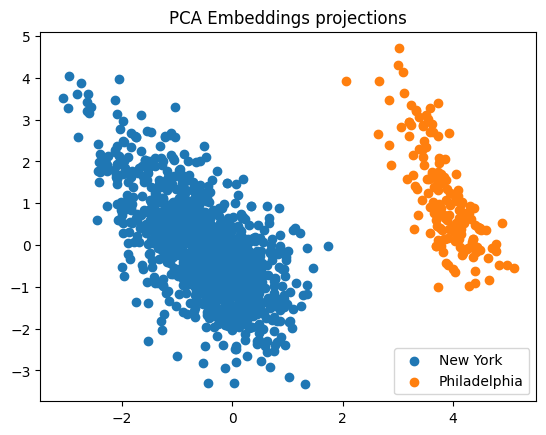

In [26]:
plt.scatter(X_pca[:len(embeddings1),0], X_pca[:len(embeddings1),1], label=TERM1)
plt.scatter(X_pca[len(embeddings1):,0], X_pca[len(embeddings1):,1], label=TERM2)
plt.legend()
plt.title("PCA Embeddings projections")

### UMAP

In [41]:
import umap
# TODO: make plot interactive with context as text
mapper = umap.UMAP().fit(all_embeddings)

Text(0.5, 1.0, 'UMAP Embeddings Projections')

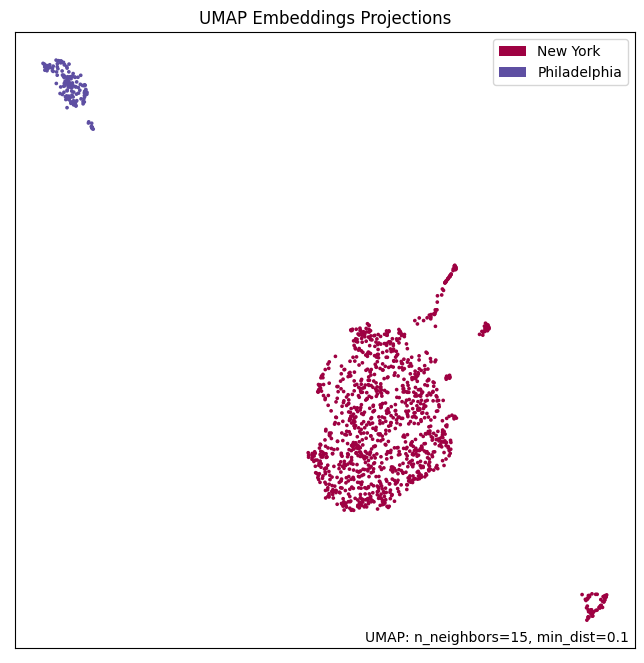

In [42]:
import umap.plot

labels = np.array(len(embeddings1) * [TERM1] + len(embeddings2) * [TERM2])
ax = umap.plot.points(mapper, labels = labels)
ax.set_title("UMAP Embeddings Projections")